In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Measuring delay between two overlapping QPSK signals


In this notebook, we'll create and send two overlapping pseudo-random QPSK signals over a noisy reception channel. We'll delay one of the signals relative to the other when simulating transmission. We'll recover this delay, with sub-sample accuracy, using correlation and measuring the distance between the peaks.

# The transmit signals (TX1 and TX2)
---

We'll simulate two transmitters. Each will send a pseudo-random QPSK signal, with TX2 delayed relative to TX1. As will be shown, pseudo-random QPSK signals have a narrow autocorrelation peak and low cross-correlation with some other pseudo-random QPSK signal. This will enable us to cleanly locate each signal at our simulated receiver, even when the two transmit signals overlap.

We now generate two pseudo-random QPSK signals. We use 4 samples per symbol (`SPS`). We'll generate a sequence of 2000 symbols (`Ns`) (totalling 4000 bits of information, as QPSK modulates 2 bits per symbol).

We'll also filter each transmit signal with a root raised cosine (RRC) filter. Later, as part of reception, we'll filter the received samples with the same filter, giving the complete end-to-end channel the response of a raised cosine (RC) filter. This is often done in digital communication systems in order to minimize inter-symbol interference (ISI).

In [2]:
Fs = 20e6  # 20 MHz sample rate
SPS = 4  # Samples per symbol
Taps = 61


def rc_filter(taps, beta=0.33):
    Ts = SPS
    t = np.arange(taps)
    t -= (taps - 1) // 2  # Center the indices around 0
    h = 1 / Ts
    h *= np.sinc(t / Ts)
    h *= np.cos(np.pi * beta * t / Ts)
    h /= 1.0 - (2.0 * beta * t / Ts) ** 2
    return h * np.sqrt(Taps)


def rrc_filter(taps, beta=0.33):
    # Create an RC filter
    hrc = rc_filter(taps, beta)

    # Take the square root of the RC filter in the frequency domain to obtain the frequency response of the
    # desired root raised cosine (RRC) filter.
    Hrc = np.fft.fft(hrc)
    Hrrc = np.sqrt(np.abs(Hrc))

    # Perform an IFFT to obtain the impulse reponse. Optionally, we could use the frequency response directly
    # and avoid the more expensive convolution operation to apply the filter (as multiplying in the frequency
    # domain is equivalent to convolution in the time domain)
    hrrc = np.fft.fftshift(np.fft.ifft(Hrrc))
    return hrrc.real


# Create and use a root raised cosine filter so that when the receiver also uses an RRC filter,
# the complete, end-to-end channel response is that of a raised cosine filter, which is pretty
# good at minimizing inter-symbol interference (ISI)
pulse = rrc_filter(taps=Taps)

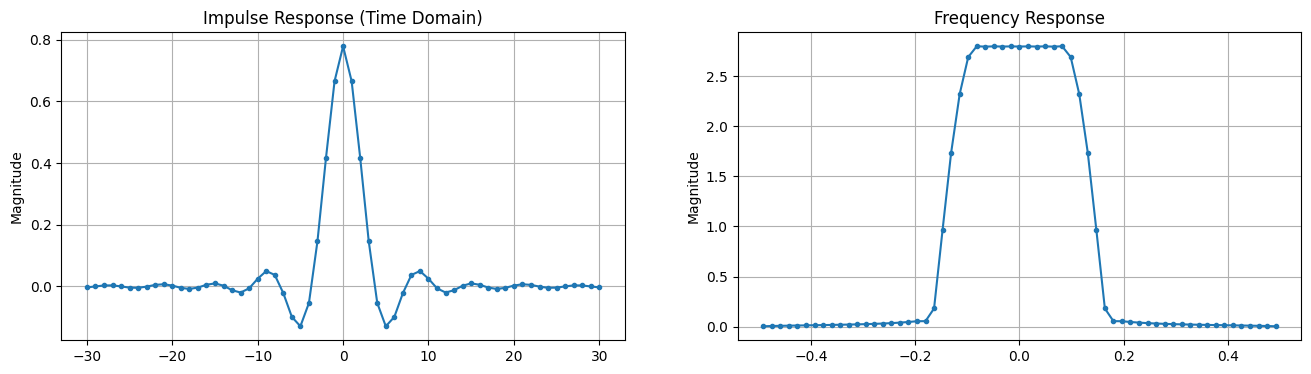

In [3]:
t = np.arange(pulse.shape[0]) - (pulse.shape[0] - 1) / 2

sp = np.fft.fftshift(np.fft.fft(pulse))
freq = np.fft.fftshift(np.fft.fftfreq(t.shape[0]))

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(t, pulse, ".-")
plt.ylabel("Magnitude")
plt.title("Impulse Response (Time Domain)")
plt.grid(True)

plt.subplot(122)
plt.plot(freq, np.abs(sp), ".-")
plt.ylabel("Magnitude")
plt.title("Frequency Response")
plt.grid(True)

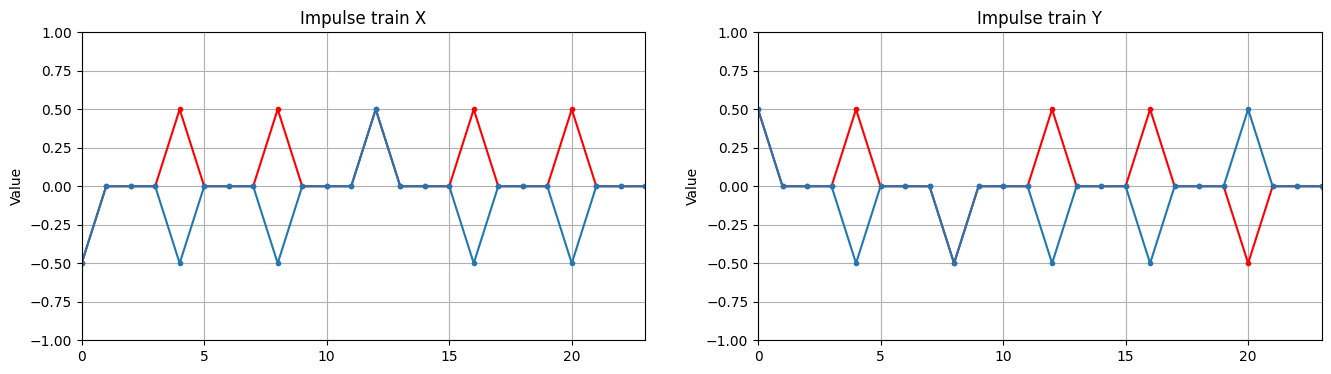

In [4]:
# Generate two complex pseudorandom sequences (pulse trains)
# The longer the sequence we generate, the more confident we can
# be at the receiver end which TX signal we are seeing and when.
Ns = 2000  # Number of symbols to generate
N = Ns * SPS  # Number of samples
BPS = 2  # QPSK has 2 bits per symbol
Nd = 23  # Number of symbols to display


def gen_pulse_train():
    sym = np.random.randint(0, BPS**2, Ns)
    s = np.zeros(N, dtype=complex)

    for i, ss in enumerate(sym):
        s[i * SPS] += (ss & 0b01) - 0.5
        s[i * SPS] += 1j * (((ss & 0b10) >> 1) - 0.5)
    return s


x = gen_pulse_train()
y = gen_pulse_train()

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(np.real(x), "r.-", np.imag(x), ".-")
plt.ylabel("Value")
plt.title("Impulse train X")
plt.xlim((0, Nd))
plt.ylim((-1, 1))
plt.grid(True)

plt.subplot(122)
plt.plot(np.real(y), "r.-", np.imag(y), ".-")
plt.ylabel("Value")
plt.title("Impulse train Y")
plt.xlim((0, Nd))
plt.ylim((-1, 1))
plt.grid(True)

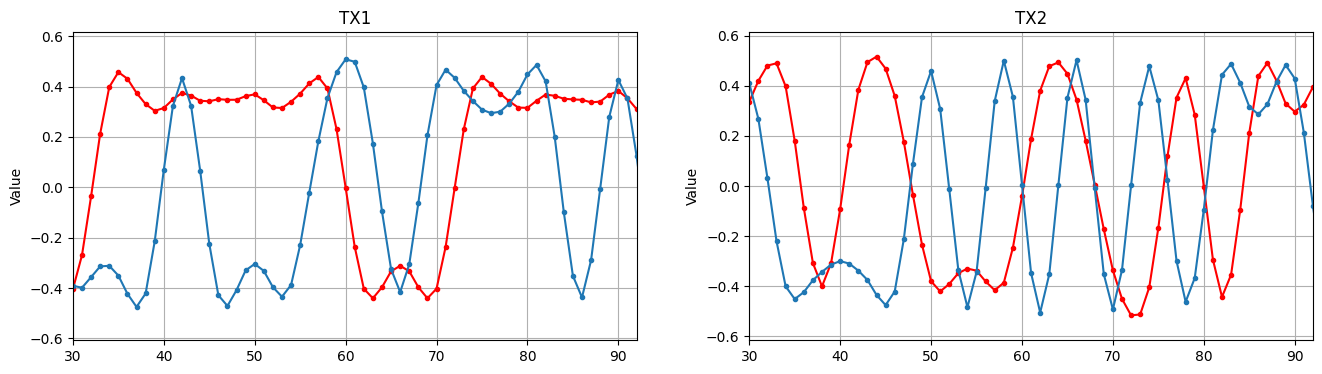

In [5]:
# Pulse shape the impulse train
tx1 = signal.convolve(x, pulse)
tx2 = signal.convolve(y, pulse)

# Convolution makes the signal a bit longer (N + Taps/2-1)
t = np.arange(tx1.shape[0])

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(np.real(tx1), "r.-", np.imag(tx1), ".-")
plt.ylabel("Value")
plt.title("TX1")
plt.xlim((Taps//2, SPS * Nd))
plt.grid(True)

plt.subplot(122)
plt.plot(np.real(tx2), "r.-", np.imag(tx2), ".-")
plt.ylabel("Value")
plt.title("TX2")
plt.xlim((Taps//2, SPS * Nd))
plt.grid(True)

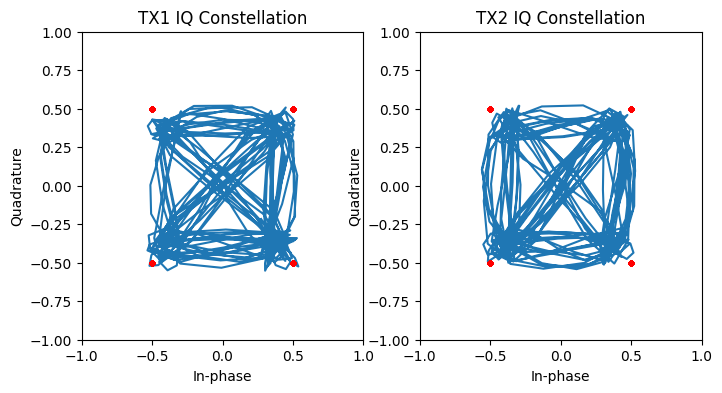

In [6]:
IQd = 500  # Raw IQ Samples to display

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("TX1 IQ Constellation")
plt.ylabel("Quadrature")
plt.xlabel("In-phase")
plt.ylim((-1, 1))
plt.xlim((-1, 1))
plt.plot(np.real(tx1[Taps//2:IQd:SPS]), np.imag(tx1[Taps//2:IQd:SPS]), "-")
plt.plot(np.real(x[0::SPS]), np.imag(x[0::SPS]), "r.")

plt.subplot(122)
plt.title("TX2 IQ Constellation")
plt.ylabel("Quadrature")
plt.xlabel("In-phase")
plt.ylim((-1, 1))
plt.xlim((-1, 1))
plt.plot(np.real(tx2[Taps//2:IQd:SPS]), np.imag(tx2[Taps//2:IQd:SPS]), "-")
plt.plot(np.real(y[0::SPS]), np.imag(y[0::SPS]), "r.")

From the IQ diagrams, we can see that the two transmission signals are both clean QPSK.

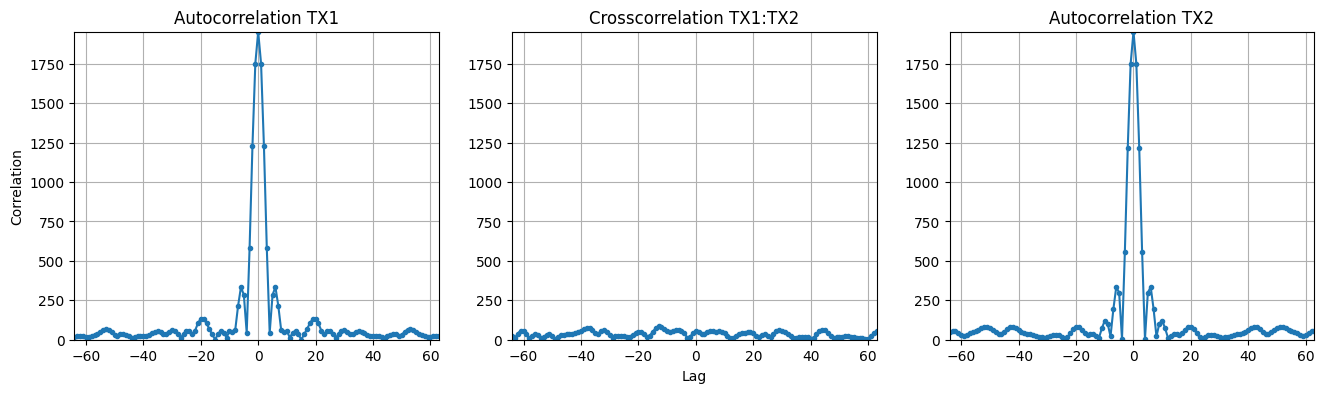

In [7]:
ac1 = signal.correlate(tx1, tx1)
ac2 = signal.correlate(tx2, tx2)
cc = signal.correlate(tx1, tx2)

t = np.arange(ac1.shape[0]) - (ac1.shape[0] - 1) / 2
top = np.max((np.abs(ac1), np.abs(ac2), np.abs(cc)))

plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.plot(t, np.abs(ac1), ".-")
plt.ylabel("Correlation")
plt.title("Autocorrelation TX1")
plt.xlim((-64, 63)) # Display the center 128 samples
plt.ylim((0, top))
plt.grid(True)

plt.subplot(132)
plt.plot(t, np.abs(cc), ".-")
plt.xlabel("Lag")
plt.title("Crosscorrelation TX1:TX2")
plt.xlim((-64, 63))
plt.ylim((0, top))
plt.grid(True)

plt.subplot(133)
plt.plot(t, np.abs(ac2), ".-")
plt.title("Autocorrelation TX2")
plt.xlim((-64, 63))
plt.ylim((0, top))
plt.grid(True)

Observe the sharp auto-correlation peaks for each transmit signal. Also observe that the transmit signals' cross-correlation is very low; they don't correlate with each other well at all. This demonstrates that our signals have the properties we expected when we constructed them.
 
### Communication channel simulation

Our next step is to simulate the communication channel. We'll add a coarse (sample level) and fine (subsample level) delay to TX2. We'll then sum the two signals together. Finally, we'll add some additive white gaussian noise (AWGN).

In [8]:
def apply_fractional_delay(s, delay=0.4):
    # Create and apply fractional delay filter
    # delay is fractional delay, in samples
    N = 23
    n = np.arange(-N // 2, N // 2)
    h = np.sinc(n - delay)
    h *= np.hamming(N)  # Window the filter to avoid edge artifacts
    h /= np.sum(h)  # Normalize
    return np.convolve(s, h)


def apply_sample_delay(s, delay=1):
    return np.concatenate((np.zeros(delay), s))


def apply_frequency_offset(s, fo=13e3):
    # Simulate a frequency offset (fo)
    Ts = 1 / Fs  # Sample period
    t = np.linspace(0, Ts * len(s), len(s))
    return s * np.exp(1j * 2 * np.pi * fo * t)  # Shift frequency by fo


def apply_noise(s, level=0.3):
    # Simulate adding AWGN
    N = len(s)  # Number of samples
    n = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)
    return s + n * level


# Note: We extend the TX1 signal by the delay amount, so that we can later sum the TX signals when simulating
# our receive channel.
delay = 2
tx1d = np.append(tx1, np.zeros(delay))
tx2d = apply_sample_delay(tx2, delay)

# Note: We apply fractional delay to both TX signals as we want to delay both equally by the filter length.
# Without this, TX2 would seem to arrive much later than TX1.
tx1d = apply_fractional_delay(tx1d, 0)
tx2d = apply_fractional_delay(tx2d, 0.5)

rx1 = (tx1d + tx2d) / np.sqrt(2)

# Note: Even a relatively small frequency offset confuses the correlation process we use
# to measure when we received the signal. For example, with a sample rate of 20 MHz, an offset
# of 13 kHz causes us to be unable to see clear correlation spikes for the two TX signals,
# but we can still see clear # peaks with a smaller offset of 500 Hz. Perhaps other waveforms
# than "random QPSK" would survive larger offsets better.
rx1 = apply_frequency_offset(rx1, 0)

rx1 = apply_noise(rx1)

### Analysis

Now, we'll analyze the received data. First, we'll filter the received data with the RRC filter composed previously, giving the overall communication channel an RC response and minimizing ISI. Second, we resample the received data; this allows us to observe properties of the received signal with subsample precision. Finally, we cross-correlate the received signals with each transmit signal; this shows us where the transmitted signals are within the receive data. We should see any delay we added here by observing the distance between cross-correlation peaks.

In [9]:
# Now that our channel is simulated, complete with signal and noise, let's filter at the receive end
# with our RRC filter. This will make the end-to-end channel response that of a raised cosine filter,
# which is good for minimizing ISI.
rx1 = signal.convolve(rx1, pulse)

In [10]:
# Interpolate signal, so we can correlate with sub-sample accuracy
RS = 10  # Increase signal length by RS times (e.g. 10x for RS 10)
rx1i = signal.resample(rx1, np.shape(rx1)[0] * RS)

# We also need to interpolate the TX signals for comparison
tx1i = signal.resample(tx1, np.shape(tx1)[0] * RS)
tx2i = signal.resample(tx2, np.shape(tx2)[0] * RS)

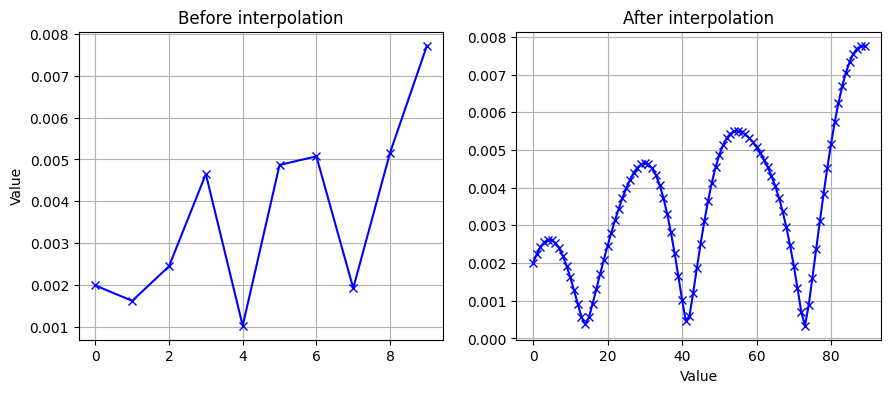

In [11]:
Nd = RS  # Number of samples to display

plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.plot(np.abs(rx1[:Nd]), "bx-")
plt.ylabel("Value")
plt.title("Before interpolation")
plt.grid(True)

plt.subplot(132)
plt.plot(np.abs(rx1i[: Nd * RS - Nd]), "bx-")
plt.xlabel("Value")
plt.title("After interpolation")
plt.grid(True)

In [12]:
rtx1 = np.abs(signal.correlate(rx1i, tx1i, "valid"))
rtx2 = np.abs(signal.correlate(rx1i, tx2i, "valid"))

Text(0.5, 1.0, 'Location of received TX signals')

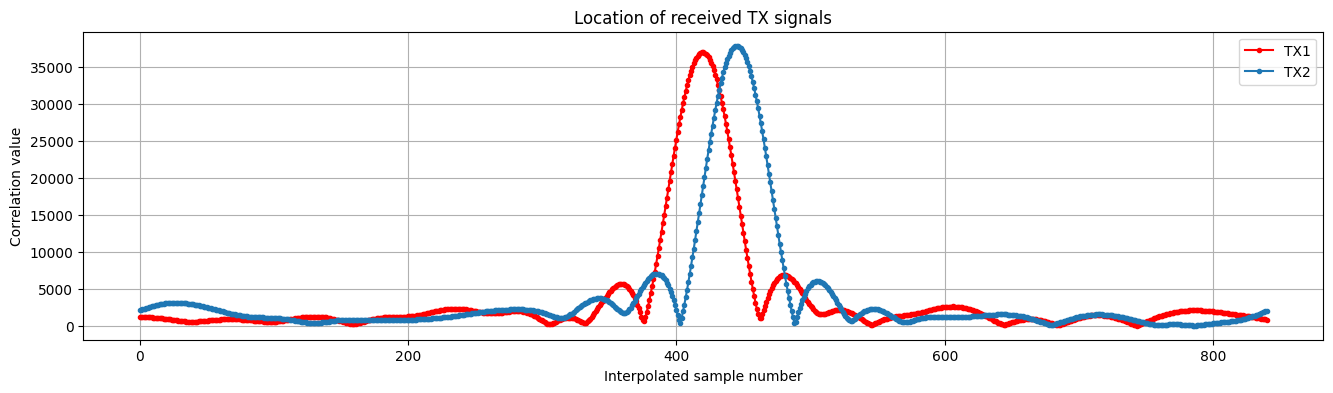

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(rtx1[: 100 * RS], "r.-")
plt.plot(rtx2[: 100 * RS], ".-")
plt.grid(True)
plt.xlabel("Interpolated sample number")
plt.ylabel("Correlation value")
plt.legend(("TX1", "TX2"))
plt.title("Location of received TX signals")

In [14]:
peak_rtx1 = np.argmax(rtx1) / float(RS)
peak_rtx2 = np.argmax(rtx2) / float(RS)

txdelay = peak_rtx2 - peak_rtx1

print("Received TX1 at offset %f" % (peak_rtx1))
print("Received TX2 at offset %f" % (peak_rtx2))
print("TX2 is behind TX1 by %f samples" % (txdelay))

Received TX1 at offset 42.000000
Received TX2 at offset 44.500000
TX2 is behind TX1 by 2.500000 samples


### Results

We see that the TX2 signal was delayed by approximately 2.5 samples relative to TX1, as intended. Our coarse (per sample) and fine (subsample) delays applied when simulating our communication channel are visible in the plot as the difference in interpolated samples between the two correlation peaks.